In [1]:
%%sh
pwd

/mnt/m/Documents/DNN Final Project/spacecraft-pose-pose-estimation-runtime/juptyer-notebooks


In [1]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.transform import Rotation
from sklearn.model_selection import train_test_split
import keras
import keras.preprocessing.image as kimg
from keras.preprocessing import image_dataset_from_directory
from keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Concatenate, Flatten, Conv2D, MaxPooling2D
from keras.applications import ResNet50, MobileNetV2
from keras.optimizers import Adam
from keras import Model
import math
from math import cos, sin
from autograd import jacobian
import tensorflow as tf
#import tensorflow_probability as tfp
#tfd = tfp.distributions
from tensorflow.data import Dataset
from tensorflow.keras.utils import image_dataset_from_directory as idfd
from keras.models import Sequential
import keras.backend as K

2024-04-21 17:09:23.311436: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 17:09:23.311524: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 17:09:23.402643: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-21 17:09:23.586973: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-21 17:09:25.327962: W tensorflow/compiler/tf2

In [2]:
root = '/mnt/m/Documents/DNN Final Project/spacecraft-pose-pose-estimation-runtime/juptyer-notebooks'

In [3]:
CAMERA_MATRIX = np.array([[5.2125371e+03, 0.0000000e+00, 6.4000000e+02],
                          [0.0000000e+00, 6.2550444e+03, 5.1200000e+02],
                          [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]])
IMAGE_WIDTH = 1280
IMAGE_HEIGHT = 1024

In [4]:
img1path = os.path.join(root, 'f7374f0bff/001_preprocessed.png')
img2path = os.path.join(root, 'f7374f0bff/002_preprocessed.png')

img1 = cv.imread(img1path, cv.IMREAD_GRAYSCALE)
img2 = cv.imread(img2path, cv.IMREAD_GRAYSCALE)

In [5]:
sift = cv.SIFT_create()

In [6]:
keypoints1, descriptor1 = sift.detectAndCompute(img1, None)
keypoints2, descriptor2 = sift.detectAndCompute(img2, None)

In [7]:
FLANN_INDEX_KDTREE = 1
indexParams = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
searchParams = dict(checks=50)
flann = cv.FlannBasedMatcher(indexParams, searchParams)
nNeighbors = 2

In [8]:
bf_feature_matcher = cv.BFMatcher()
matches = bf_feature_matcher.knnMatch(descriptor1,descriptor2,k=2)

In [9]:
goodMatches = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        goodMatches.append([m])

print(f'Num good matches: {len(goodMatches)}')
minGoodMatches = 10

Num good matches: 19


In [10]:
def Get5PointSolution(img1, img2):
    sift = cv.SIFT_create()
    keypoints1, descriptor1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptor2 = sift.detectAndCompute(img2, None)
    bf_feature_matcher = cv.BFMatcher()
    matches = bf_feature_matcher.knnMatch(descriptor1,descriptor2,k=2)
    goodMatches = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            goodMatches.append([m])

    points1 = np.float32([keypoints1[m[0].queryIdx].pt for m in goodMatches]).reshape(-1, 1, 2)
    points2 = np.float32([keypoints2[m[0].trainIdx].pt for m in goodMatches]).reshape(-1, 1, 2)


    E, _ = cv.findEssentialMat(points1, points2, CAMERA_MATRIX)
    _, R, t, _ = cv.recoverPose(E, points1, points2, CAMERA_MATRIX)

In [15]:
#green = (0, 255, 0)
#drawParams = dict(matchColor=green, singlePointColor=None, matchesMask=matchesMask, flags=cv.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

imgMatch = cv.drawMatchesKnn(img1, keypoints1, img2, keypoints2, goodMatches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

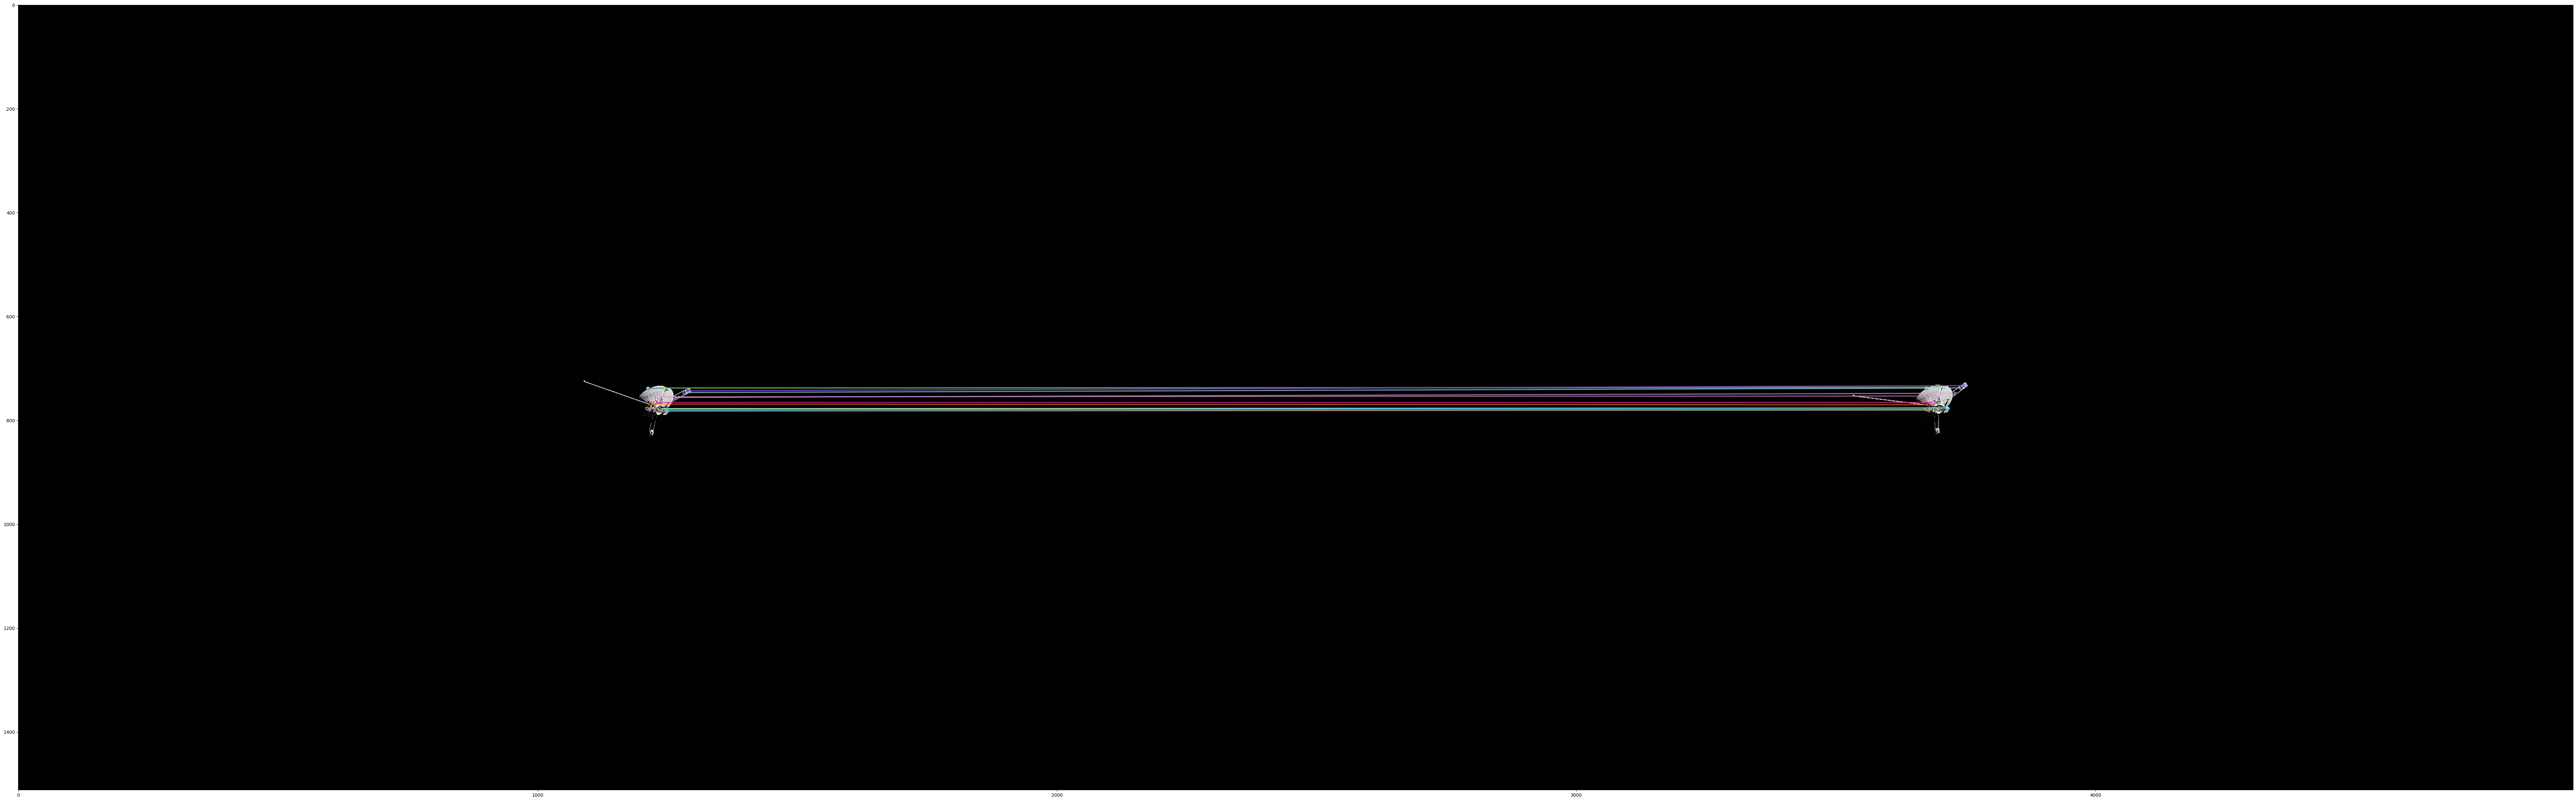

In [32]:
plt.figure(figsize=(100,100))
plt.imshow(imgMatch, 'gray')
plt.show()

In [1]:
# img_rgb = cv.cvtColor(cv.imread(img1path), cv.COLOR_BGR2RGB)
# cv.imshow('Image', img_rgb)
# cv.waitKey(0)
# cv.destroyAllWindows()

In [11]:
def PerspectiveProjection(r, t, point):
    rz, ry, rx = r[0], r[1], r[2]
    x, y, z = t[0] - point[0], t[1] - point[1], t[2] - point[2]
    
    d_x = cos(ry) * (sin(rz) * y + cos(rz) * x) - sin(ry) * z
    d_y = sin(rx) * (cos(ry) * z + sin(ry)*(sin(rz) * y + cos(rz) * x)) + cos(rx) * (cos(rz) * y + sin(rz) * x)
    d_z = cos(rx) * (cos(ry) * z + sin(ry)*(sin(rz) * y + cos(rz) * x)) - sin(rx) * (cos(rz) * y + sin(rz) * x)

    b_x = IMAGE_WIDTH / 2 * d_x / d_z
    b_y = IMAGE_HEIGHT / 2 * d_y / d_z

    return (b_x, b_y)

def BundleAdjustment(theta):
    r, t, x, x_1, x_2 = theta[0], theta[1], theta[2], theta[3], theta[4]
    alpha = math.acos(t[0])
    beta = math.acos(t[1] / math.sin(alpha))

    print(r)
    print(t)
    print(x_1[0])

    min_sum = math.inf
    min_theta = 0

    for i in range(len(x)):
        X = x[i]
        xi1 = x_1[i]
        xi2 = x_2[i]

        sum = np.linalg.norm(xi1 - PerspectiveProjection([0,0,0], [0,0,0], X)) + np.linalg.norm(xi2 - PerspectiveProjection(r, t, X))
        if (sum < min_sum):
            min_sum = sum
            min_theta = i
    
    return min_theta


In [98]:
# 5-point equation geometric solver
points1 = np.float32([keypoints1[m[0].queryIdx].pt for m in goodMatches]).reshape(-1, 1, 2)
points2 = np.float32([keypoints2[m[0].trainIdx].pt for m in goodMatches]).reshape(-1, 1, 2)


E, _ = cv.findEssentialMat(points1, points2, CAMERA_MATRIX)
_, R, t, _ = cv.recoverPose(E, points1, points2, CAMERA_MATRIX)

# print(R)
# print("\n")
# r, _ = cv.Rodrigues(R)
# rot = Rotation.from_rotvec(r.T[0])
#print(points.T)
points[0] = points[0] / points[3]
points[1] = points[1] / points[3]
points[2] = points[2] / points[3]
points[3] = 1
print(points[0:3].T)
pts, j  = cv.projectPoints(points[0:3].T, R, t, CAMERA_MATRIX, np.array([]))
# j = jacobian(BundleAdjustment)
# print(j(np.array([rot.as_euler("zyx"), t, points, points1, points2])))
# print(BundleAdjustment(rot.as_euler("zyx"), t, points, points1, points2))

#print(Rotation.from_rotvec(r.T[0]).as_quat())

print("\n")
print(t)
print("\n")
# print(j.T)
print(j)
# print(j.T.dot(j))

#print(points)
#infMatrix

[[0.21272014 0.0823497  1.94065896]
 [0.21288522 0.06994049 1.9383241 ]
 [0.21470456 0.0827724  1.94020316]
 [0.21470456 0.0827724  1.94020316]
 [0.21487731 0.07969315 1.94073126]
 [0.21833015 0.07865957 1.93993465]
 [0.22032912 0.08245584 1.93697386]
 [0.2209091  0.07522405 1.93840469]
 [0.22128249 0.08235604 1.93829841]
 [0.22128249 0.08235604 1.93829841]
 [0.22122122 0.08370414 1.93720134]
 [0.22122122 0.08370414 1.93720134]
 [0.22163942 0.08149479 1.93808728]
 [0.22400032 0.07000135 1.9399739 ]
 [0.2259895  0.08305028 1.93455169]
 [0.23096634 0.0752226  1.93169838]
 [0.23817633 0.07247623 1.93171315]
 [0.23916185 0.07123099 1.93157717]
 [0.24078457 0.07143642 1.93069563]]


[[ 0.95205995]
 [-0.26790123]
 [ 0.14768475]]


[[-5.05914940e+02  4.61659738e+03 -5.58266280e+02  2.71216462e+03
   0.00000000e+00 -2.99049790e+02  1.10262404e-01  0.00000000e+00
   1.00000000e+00  0.00000000e+00  8.03632083e+00  1.12366776e-01
   4.91005809e+01  1.99629542e+02  1.57115334e-03]
 [-6.16650620e+0

In [57]:
print(len(points1))
print(len(points2))
print([[a[0][0],b.tolist()[0]] for (a,b) in zip(points1,points2)])

19
19
[[1211.377, [1214.7117919921875, 779.0403442382812]], [1212.5452, [1214.1480712890625, 737.8350219726562]], [1216.8239, [1219.9888916015625, 779.86376953125]], [1216.8239, [1219.9888916015625, 779.86376953125]], [1217.1339, [1218.416015625, 770.0484008789062]], [1226.6381, [1226.907958984375, 765.6121215820312]], [1232.9216, [1237.32666015625, 776.2215576171875]], [1234.0436, [1233.7139892578125, 753.2662963867188]], [1235.0667, [1237.32666015625, 776.2215576171875]], [1235.0667, [1237.32666015625, 776.2215576171875]], [1235.2494, [1239.390869140625, 780.1173095703125]], [1235.2494, [1239.390869140625, 780.1173095703125]], [1236.1051, [1238.103271484375, 773.1715087890625]], [1241.8657, [1236.1396484375, 736.2691650390625]], [1248.9426, [1253.748046875, 775.5859985351562]], [1263.2911, [1266.277099609375, 747.8851928710938]], [1282.6888, [1281.1064453125, 737.619873046875]], [1285.3944, [1283.014892578125, 733.3109741210938]], [1290.0758, [1288.0203857421875, 733.1932373046875]]]

In [ ]:
class FusionLayer(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)

    def build(self, batch_input_shape):
        self.kernel = self.add_weight(
            name="kernel", shape=[batch_input_shape[-1], self.units],
            initializer="glorot_normal")
        self.bias = self.add_weight(
            name="bias", shape=[self.units], initializer="zeros")
        super().build(batch_input_shape) # must be at the end

    def call(self, X):
        return self.activation(X @ self.kernel + self.bias)

    def compute_output_shape(self, batch_input_shape):
        return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units])

    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "units": self.units,
                "activation": keras.activations.serialize(self.activation)}

In [12]:
def stack_imgs(gen1):
    curr_id = ""
    while True:
        nextimg = next(gen1)
        if nextimg["chain_id"] != curr_id:
            curr_ref = nextimg
        yield([curr_ref, nextimg]) # combine next img with its reference image

In [4]:
def load_and_preprocess_image(path, base_path):
  raw = tf.io.read_file(path)
  image = tf.image.resize(tf.image.decode_png(raw, channels=3), (512,640))
  base_raw = tf.io.read_file(base_path)
  base_image = tf.image.resize(tf.image.decode_png(base_raw, channels=3), (512,640))

  return [base_image, image]

dfY = pd.read_csv("../data/train_labels.csv")
dfY["path"] = [f"../data/images/{id}/{i:03d}.png" for id, i in zip(dfY["chain_id"], dfY["i"])]
dfY["base_path"] = [f"../data/images/{id}/000.png" for id, i in zip(dfY["chain_id"], dfY["i"])]
x_train, x_test, y_train, y_test = train_test_split(dfY[["path", "base_path"]], dfY[["x","y","z","qw","qx","qy","qz"]], test_size=0.02)
x_train = pd.DataFrame(x_train, columns=["path", "base_path"])
x_test = pd.DataFrame(x_test, columns=["path", "base_path"])
#df_labels = dfY[["x","y","z","qw","qx","qy","qz"]]
#dfY.drop(["chain_id", "i", "x","y","z","qw","qx","qy","qz"], axis=1, inplace=True)
#print(dfY)
#dfY = np.asarray(dfY).astype(np.float32)
#dfY.drop(["chain_id", "i"], axis=1, inplace=True)
#print(dfY)
#ds = tf.data.Dataset.from_tensor_slices((dfY, {"x": "x", "y": "y", "z": "z", "qw": "qw", "qx": "qx", "qy": "qy", "qz": "qz"}))

# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(path, base_path, label):
  return load_and_preprocess_image(path, base_path), label

# train_images = x_train.apply(lambda x: load_and_preprocess_image(x["path"],x["base_path"]), axis=1)
# test_images = x_test.apply(lambda x: load_and_preprocess_image(x["path"],x["base_path"]), axis=1)
# # print(type(image_label_ds[0]))
# # print(image_label_ds[:,0])
# base_images = [x[0] for x in train_images]
# images = [x[1] for x in train_images]
# base_images_test = [x[0] for x in test_images]
# images_test = [x[1] for x in test_images]
# print(np.asarray(base_images).shape)
# for elem in image_label_ds.take(1):
#   print(elem[0][0].shape)
#print(list(image_label_ds.as_numpy_iterator())[0][0])

In [6]:
def flow_from_df(dataframe: pd.DataFrame, chunk_size: int = 10):
    for start_row in range(0, dataframe.shape[0], chunk_size):
        end_row  = min(start_row + chunk_size, dataframe.shape[0])
        yield dataframe.iloc[start_row:end_row, :]
get_chunk = flow_from_df(x_train, 100)

def load_new_batch():
    train_images = next(get_chunk).apply(lambda x: load_and_preprocess_image(x["path"],x["base_path"]), axis=1)
    base_images = [x[0] for x in train_images]
    images = [x[1] for x in train_images]
    del train_images

    return base_images, images

In [33]:
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv')

# Loads all images found and trains given model
def load_images_and_train_model(model):
    with tf.device('/GPU:0'):
        model.summary()
        
        #for i in range(batches):
            #batch = load_new_batch()
            #model.fit([np.asarray(batch[0]), np.asarray(batch[1])], y_train[100 * i : 100*(i+1)], epochs=40, batch_size=batch_size_b)
        model.fit(CustomDataGenerator(x_train, y_train, batch_size=25), epochs=40)
            #del batch

        
    #     ypreddf = pd.DataFrame(ypred.T, index=image_label_ds.take(count * 100 * 0.2).index_array, columns=["x", "y", "z"])
    #     dfY = pd.read_csv("../data/train_labels.csv")[:count * 100]
    #     dfY_merged = pd.merge(ypreddf.drop(["x", "y", "z"], axis=1), dfY, left_index=True, right_index=True)
    #     dfYidx = dfY.drop(["x", "y", "z", "qw", "qx", "qy", "qz"], axis=1)
    #     df_merged = pd.merge(ypreddf, dfYidx, left_index=True, right_index=True)
    #     df_merged["qw"] = 0
    #     df_merged["qx"] = 0
    #     df_merged["qy"] = 0
    #     df_merged["qz"] = 0
    #     df_merged.loc[df_merged["i"] == 0, ["x", "y", "z", "qw", "qx", "qy", "qz"]] = [0,0,0,1,0,0,0]
    #     df_merged.set_index(["chain_id", "i"], inplace=True)
    #    # df_merged.drop(["id"], axis=1, inplace=True)
    #     ToCSV(df_merged, "cnn-test")
    #     ToCSV(dfY_merged, "cnn-true")

    return model

In [10]:
test_images = x_test[0:50].apply(lambda x: load_and_preprocess_image(x["path"],x["base_path"]), axis=1)
base_images_test = [x[0] for x in test_images]
images_test = [x[1] for x in test_images]
ypred = pd.DataFrame(model.predict([np.asarray(base_images_test), np.asarray(images_test)]), index=y_test[0:50].index, columns=["x", "y", "z", "qw", "qx", "qy", "qz"])
#ypred[["qw", "qx", "qy", "qz"]] = ypred[["qw", "qx", "qy", "qz"]].clip(lower=-1, upper=1)
#print(ypred)
#print(y_test[0:50])
ypred["chain_id"] = dfY.iloc[ypred.index].chain_id
ypred["i"] = dfY.iloc[ypred.index].i.astype(int)
ypred["qw"] = ypred["qw"] / np.linalg.norm(ypred[["qw", "qx", "qy", "qz"]], axis=1)
ypred["qx"] = ypred["qx"] / np.linalg.norm(ypred[["qw", "qx", "qy", "qz"]], axis=1)
ypred["qy"] = ypred["qy"] / np.linalg.norm(ypred[["qw", "qx", "qy", "qz"]], axis=1)
ypred["qz"] = ypred["qz"] / np.linalg.norm(ypred[["qw", "qx", "qy", "qz"]], axis=1)
#ypred[["x", "y", "z", "qw", "qx", "qy", "qz"]] = [0,0,0,0,0,0,0]
ypred.set_index(["chain_id", "i"], inplace=True)
ToCSV(ypred, "cnn-test")
y_copy = y_test.copy()
y_copy["chain_id"] = dfY.iloc[y_copy.index].chain_id
y_copy["i"] = dfY.iloc[y_copy.index].i.astype(int)
y_copy.set_index(["chain_id", "i"], inplace=True)
ToCSV(y_copy[0:50], "cnn-true")

2024-04-21 17:14:58.715763: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.45GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


2/2 [==============================] - 25s 8s/step


In [8]:
# from https://github.com/1988kramer/camera-pose/blob/master/camera-pose.py 
def create_conv_branch(input_shape):
	model = Sequential()
	model.add(Conv2D(96, kernel_size=(11,11),
					 strides=4, padding='valid',
					 activation='relu',
					 input_shape=input_shape))
	model.add(MaxPooling2D(pool_size=(2,2), strides=2))
	model.add(Conv2D(256, kernel_size=(5,5),
					 strides=1, padding='same',
					 activation='relu'))
	model.add(MaxPooling2D(pool_size=(3,3), strides=1))
	model.add(Conv2D(384, kernel_size=(3,3),
					 strides=1, padding='same',
					 activation='relu'))
	model.add(Conv2D(384, kernel_size=(3,3),
					 strides=1, padding='same',
					 activation='relu'))
	model.add(Conv2D(256, kernel_size=(3,3),
					 strides=1, padding='same',
					 activation='relu'))
	# replace with SPP if possible
	model.add(MaxPooling2D(pool_size=(3,3), strides=2))
	return model

In [30]:
# https://stackoverflow.com/questions/63827339/how-to-build-a-custom-data-generator-for-keras-tf-keras-where-x-images-are-being
class CustomDataGenerator(tf.keras.utils.Sequence):

    ''' Custom DataGenerator to load img 
    
    Arguments:
        data_frame = pandas data frame in filenames and labels format
        batch_size = divide data in batches
        shuffle = shuffle data before loading
        img_shape = image shape in (h, w, d) format
        augmentation = data augmentation to make model rebust to overfitting
    
    Output:
        Img: numpy array of image
        label : output label for image
    '''
    
    def __init__(self, data_frame, labels, batch_size=10, img_shape=None, augmentation=True, num_classes=None):
        self.data_frame = data_frame
        self.labels = labels
        self.train_len = len(data_frame)
        self.batch_size = batch_size
        self.img_shape = img_shape
        self.num_classes = num_classes
        print(f"Found {self.data_frame.shape[0]} images belonging to {self.num_classes} classes")

    def __len__(self):
        ''' return total number of batches '''
        #self.data_frame = shuffle(self.data_frame)
        return math.ceil(self.train_len/self.batch_size)

    def on_epoch_end(self):
        ''' shuffle data after every epoch '''
        # fix on epoch end it's not working, adding shuffle in len for alternative
        pass
    
    def __data_augmentation(self, img):
        ''' function for apply some data augmentation '''
        img = tf.image.resize(img, 512, 640)
        img = tf.image.random_flip_up_down(img)
        return img
        
    def __get_image(self, file_id):
        """ open image with file_id path and apply data augmentation """
        img = np.asarray(Image.open(file_id))
        img = np.resize(img, self.img_shape)
        img = self.__data_augmentation(img)

        return img

    def __get_label(self, label_id):
        """ uncomment the below line to convert label into categorical format """
        #label_id = tf.keras.utils.to_categorical(label_id, num_classes)
        return label_id

    def __getitem__(self, idx):
        # batch_x = self.data_frame["filenames"][idx * self.batch_size:(idx + 1) * self.batch_size]
        # batch_y = self.data_frame["labels"][idx * self.batch_size:(idx + 1) * self.batch_size]
        # # read your data here using the batch lists, batch_x and batch_y
        # x = [self.__get_image(file_id) for file_id in batch_x] 
        # y = [self.__get_label(label_id) for label_id in batch_y]

        y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        paths = self.data_frame["path"][idx * self.batch_size:(idx + 1) * self.batch_size]
        base_paths = self.data_frame["base_path"][idx * self.batch_size:(idx + 1) * self.batch_size]

        #raw = [tf.io.read_file(path) for path in paths]
        image = [tf.image.resize(tf.image.decode_png(tf.io.read_file(path), channels=3), (512,640)) for path in paths]
        #base_raw = tf.io.read_file(base_path)
        base_image = [tf.image.resize(tf.image.decode_png(tf.io.read_file(path), channels=3), (512,640)) for path in base_paths]

        return [np.asarray(base_image), np.asarray(image)], y

        #return tf.convert_to_tensor(x), tf.convert_to_tensor(y)

In [11]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

def gaussian_nll(ytrue, ypreds):
    """Keras implmementation of multivariate Gaussian negative loglikelihood loss function. 
    This implementation implies diagonal covariance matrix.
    
    Parameters
    ----------
    ytrue: tf.tensor of shape [n_samples, n_dims]
        ground truth values
    ypreds: tf.tensor of shape [n_samples, n_dims*2]
        predicted mu and logsigma values (e.g. by your neural network)
        
    Returns
    -------
    neg_log_likelihood: float
        negative loglikelihood averaged over samples
        
    This loss can then be used as a target loss for any keras model, e.g.:
        model.compile(loss=gaussian_nll, optimizer='Adam') 
    
    """
    
    n_dims = ypreds.shape[1]#int(int(ypreds.shape[1])/2)
    print(n_dims)
    mu = ypreds[:, 0:n_dims]
    logsigma = ypreds[:, :]
    
    mse = -0.5*K.sum(K.square((ytrue-ypreds)/K.exp(ypreds)),axis=1)
    sigma_trace = -K.sum(ypreds, axis=1)
    log2pi = -0.5*n_dims*np.log(2*np.pi)
    
    log_likelihood = mse+sigma_trace+log2pi

    return K.mean(-log_likelihood)

In [34]:
# Correspondences encode - encode to d=128
# Stack correspondences (x^1_i, x^2_i) to x^12 in R^(nx4)
#stackedImg = [img1, img2]
#print(stackedCorr)
input_shape=(512, 640, 3)
# ResNet
# referenceNet = MobileNetV2(include_top=False, input_shape=(640, 512, 3))
# imageNet = MobileNetV2(include_top=False, input_shape=(640, 512, 3))
# x1 = referenceNet.output
# x1 = GlobalAveragePooling2D()(x1)
# x1 = Dropout(0.5)(x1)
conv_branch = create_conv_branch(input_shape)
branch_a = Input(shape=input_shape)
branch_b = Input(shape=input_shape)

processed_a = conv_branch(branch_a)
processed_b = conv_branch(branch_b)

concat = keras.layers.concatenate([processed_a, processed_b])

x1 = Flatten()(concat)
x1 = Dense(128)(x1)
x1 = Dense(64)(x1)
x1 = Dense(32)(x1)
output = Dense(7)(x1)
# x1 = Dense(1)(x1)
# x = Dense(1)(x1)
# y = Dense(1)(x1)
# z = Dense(1)(x1)
# qw = Dense(1)(x1)
# qx = Dense(1)(x1)
# qy = Dense(1)(x1)
# qz = Dense(1)(x1)
# output = tfp.layers.DistributionLambda(
#       lambda t: tfd.Normal(loc=t[..., :1],
#                            scale=1e-3 + tf.math.softplus(0.05 * t[...,1:])))(output)

model = Model(inputs=[branch_a,branch_b], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0001), loss="mae")
model.summary()
load_images_and_train_model(model)

# yhat = model(x_test)
# var_inv = 1 / yhat.variance()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 512, 640, 3)]        0         []                            
                                                                                                  
 input_20 (InputLayer)       [(None, 512, 640, 3)]        0         []                            
                                                                                                  
 sequential_9 (Sequential)   (None, 30, 38, 256)          3747200   ['input_19[0][0]',            
                                                                     'input_20[0][0]']            
                                                                                                  
 concatenate_9 (Concatenate  (None, 30, 38, 512)          0         ['sequential_9[0][0]',  

2024-04-21 17:34:28.183223: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.36GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-21 17:34:28.815400: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.36GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-21 17:34:29.013916: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.36GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-21 17:34:32.223551: W external/local_tsl/tsl/framework/bfc_

  58/2588 [..............................] - ETA: 1:45:18 - loss: 59.4578

KeyboardInterrupt: 

In [ ]:
for i in 

In [59]:
# Correspondences encode - encode to d=128
# Stack correspondences (x^1_i, x^2_i) to x^12 in R^(nx4)
stackedCorr = [[a[0][0], a[0][1], b[0][0], b[0][1]] for (a,b) in zip(points1, points2)]
#print(stackedCorr)

m = keras.models.Sequential([
    Input(shape=(None, 4)),
    Dense(128, activation="relu")# Embed correspondences to d=128
    # Create graph CNN
    # Concat to ResNet
])
m.summary()
m.compile()
m.fit()

2024-03-25 23:45:46.499293: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-25 23:45:46.777884: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-25 23:45:46.778160: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-25 23:45:46.780087: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-25 23:45:46.780382: I external/local_xla/xla/stream_executor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, None, 128)         640       
                                                                 
Total params: 640 (2.50 KB)
Trainable params: 640 (2.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
def calculate_pose(homography_matrix):
    # Extract rotation and translation from homography matrix
    rot_matrix = np.zeros((3, 3))
    rot_matrix[:, :2] = homography_matrix[:, :2]
    rot_matrix[:, 2] = np.cross(rot_matrix[:, 0], rot_matrix[:, 1])
    translation = homography_matrix[:, 2] / np.linalg.norm(homography_matrix[:, :2])

    # Convert rotation matrix to quaternion
    trace = np.trace(rot_matrix)
    if trace > 0:
        s = 0.5 / np.sqrt(trace + 1.0)
        w = 0.25 / s
        x = (rot_matrix[2, 1] - rot_matrix[1, 2]) * s
        y = (rot_matrix[0, 2] - rot_matrix[2, 0]) * s
        z = (rot_matrix[1, 0] - rot_matrix[0, 1]) * s
    else:
        if rot_matrix[0, 0] > rot_matrix[1, 1] and rot_matrix[0, 0] > rot_matrix[2, 2]:
            s = 2.0 * np.sqrt(1.0 + rot_matrix[0, 0] - rot_matrix[1, 1] - rot_matrix[2, 2])
            w = (rot_matrix[2, 1] - rot_matrix[1, 2]) / s
            x = 0.25 * s
            y = (rot_matrix[0, 1] + rot_matrix[1, 0]) / s
            z = (rot_matrix[0, 2] + rot_matrix[2, 0]) / s
        elif rot_matrix[1, 1] > rot_matrix[2, 2]:
            s = 2.0 * np.sqrt(1.0 + rot_matrix[1, 1] - rot_matrix[0, 0] - rot_matrix[2, 2])
            w = (rot_matrix[0, 2] - rot_matrix[2, 0]) / s
            x = (rot_matrix[0, 1] + rot_matrix[1, 0]) / s
            y = 0.25 * s
            z = (rot_matrix[1, 2] + rot_matrix[2, 1]) / s
        else:
            s = 2.0 * np.sqrt(1.0 + rot_matrix[2, 2] - rot_matrix[0, 0] - rot_matrix[1, 1])
            w = (rot_matrix[1, 0] - rot_matrix[0, 1]) / s
            x = (rot_matrix[0, 2] + rot_matrix[2, 0]) / s
            y = (rot_matrix[1, 2] + rot_matrix[2, 1]) / s
            z = 0.25 * s

    return translation, [x, y, z, w]


In [36]:
translation, quat = calculate_pose(M)

In [37]:
translation

array([620.71499515, 508.70476913,   0.92980055])

In [38]:
quat

[-0.00029664116316386924,
 -0.00031669406374587117,
 0.719521014529947,
 0.049691004139257325]

In [50]:
def move_image(image_path, pose):
    # Read the image
    image = cv.imread(image_path)
    
    # Extract translation and rotation from the pose
    translation = pose[:3]
    quaternion = pose[3:]
    
    # Convert quaternion to rotation matrix
    rotation = Rotation.from_quat(quaternion).as_matrix()
    
    # Apply translation
    translation_matrix = np.eye(4)
    translation_matrix[:3, 3] = translation
    # Apply rotation
    transformation_matrix = np.eye(4)
    transformation_matrix[:3, :3] = rotation
    
    # Apply transformation to image
    rows, cols, _ = image.shape
    new_image = cv.warpPerspective(image, transformation_matrix[:3], (cols, rows))
    
    return new_image

In [54]:
# Move the image
pose = [7.64022827,-46.98920059,-42.21747971,0.98997474,-0.0941886,-0.07856753,0.07003857]
# new_image = move_image(img1path, pose)

# # Show the original and moved image
# cv.imshow('Original Image', cv.imread(img1path))
# cv.imshow('Moved Image', new_image)
# cv.waitKey(0)
# cv.destroyAllWindows()

In [113]:
image = cv.imread(img1path)
translation = np.float32(pose[:3])
quaternion = np.float32(pose[3:])
rotation = Rotation.from_quat(quaternion).as_matrix().astype(np.float32)

In [114]:
quaternion
print(type(quaternion))

<class 'numpy.ndarray'>


In [85]:
def quaternion_to_rotation_matrix(q):
    # Extract quaternion components
    qw, qx, qy, qz = q
    # Compute rotation matrix
    R = np.array([[1 - 2*qy**2 - 2*qz**2, 2*qx*qy - 2*qz*qw, 2*qx*qz + 2*qy*qw],
                  [2*qx*qy + 2*qz*qw, 1 - 2*qx**2 - 2*qz**2, 2*qy*qz - 2*qx*qw],
                  [2*qx*qz - 2*qy*qw, 2*qy*qz + 2*qx*qw, 1 - 2*qx**2 - 2*qy**2]])
    return R

In [88]:
R = quaternion_to_rotation_matrix(quaternion)
transformation_matrix = np.identity(4)
transformation_matrix[:3, :3] = R
transformation_matrix[:3, 3] = translation

In [115]:
rotation.dtype

dtype('float32')

In [117]:
cv.warpAffine(image, rotation, (1280, 1024))

error: OpenCV(4.9.0) /home/conda/feedstock_root/build_artifacts/libopencv_1704864625327/work/modules/imgproc/src/imgwarp.cpp:2757: error: (-215:Assertion failed) (M0.type() == CV_32F || M0.type() == CV_64F) && M0.rows == 2 && M0.cols == 3 in function 'warpAffine'


In [97]:
transformation_matrix

array([[  0.97784348,  -0.1238725 ,  -0.16875341,   7.64022827],
       [  0.15347316,   0.97244621,   0.17548315, -46.98920059],
       [  0.14236607,  -0.19749418,   0.9699113 , -42.21747971],
       [  0.        ,   0.        ,   0.        ,   1.        ]])

In [93]:
# Normalize transformation matrix
transformation_matrix = transformation_matrix / transformation_matrix[3, 3]

# Extract rotation and translation components
rotation_matrix = transformation_matrix[0:3, 0:3]
translation_vector = transformation_matrix[0:3, 3]

projection_matrix = np.hstack([rotation_matrix, translation_vector.reshape(3, 1)])

In [96]:
transformed_image = cv.warpPerspective(image, projection_matrix, (image.shape[1], image.shape[0]))

error: OpenCV(4.9.0) /home/conda/feedstock_root/build_artifacts/libopencv_1704864625327/work/modules/imgproc/src/imgwarp.cpp:3323: error: (-215:Assertion failed) (M0.type() == CV_32F || M0.type() == CV_64F) && M0.rows == 3 && M0.cols == 3 in function 'warpPerspective'


In [91]:
transformed_image = cv.warpPerspective(image, transformation_matrix, (image.shape[1], image.shape[0]))

error: OpenCV(4.9.0) /home/conda/feedstock_root/build_artifacts/libopencv_1704864625327/work/modules/imgproc/src/imgwarp.cpp:3323: error: (-215:Assertion failed) (M0.type() == CV_32F || M0.type() == CV_64F) && M0.rows == 3 && M0.cols == 3 in function 'warpPerspective'


In [65]:
# Combine translation and rotation into transformation matrix
transformation_matrix = np.eye(4)
transformation_matrix[:3, :3] = rotation
transformation_matrix[:3, 3] = translation

In [67]:
rows, cols, _ = image.shape

In [69]:
new_image = cv.warpPerspective(image, transformation_matrix[:3], (cols, rows))

error: OpenCV(4.9.0) /home/conda/feedstock_root/build_artifacts/libopencv_1704864625327/work/modules/imgproc/src/imgwarp.cpp:3323: error: (-215:Assertion failed) (M0.type() == CV_32F || M0.type() == CV_64F) && M0.rows == 3 && M0.cols == 3 in function 'warpPerspective'
